In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN


In [7]:
#get starting points 
startingPoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        timePoint = row['Timestep'] + 1
        startingPoints.append(timePoint)

In [8]:
def getTimeFromStart(current, startList):
    currentEpisodeStartIndex = -1 #initialise negative value first
    for s in range(len(startList)):
        start = startList[s]
        if start - current > 0: 
            break 
        currentEpisodeStartIndex = s
    if currentEpisodeStartIndex >= 0:
        startPointTime = startList[currentEpisodeStartIndex]
        diff = current - startPointTime
        return int(diff)
    else: 
        return current

In [9]:
#get data on time elapsed from start of episode 
total_time_from_start = []
for timePoint in timeX:
    current_time_from_start = getTimeFromStart(timePoint, startingPoints)
    total_time_from_start.append(current_time_from_start)

In [10]:
all_df['Time_elapsed'] = total_time_from_start
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL,Time_elapsed
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0,0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0,1
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0,2
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0,3
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0,4
...,...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN,3
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN,4
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN,5
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN,6


In [11]:
#add anomaly data

#load anomaly detection model
anomalyDetector = tf.keras.models.load_model('AE_tuneActivation_code_relu.h5')

anomalyData = []

for index, row in all_df.iterrows():
    sensorReadings = np.array([row['Volt'], row['Rotate'], row['Pressure'], row['Vibration']])
    sensorReadings = np.reshape(sensorReadings, (1,4))
    predictions = anomalyDetector.predict(sensorReadings)
    anomalyScore = (np.mean(np.power(sensorReadings - predictions, 2), axis=1))**0.5
    
    if anomalyScore < 0.0838:
        isAnomaly = 0
    else:
        isAnomaly = 1
        
    anomalyData.append(isAnomaly)
    
all_df['Anomalous'] = anomalyData

In [12]:
#drop na columns 
all_df = all_df.dropna()
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL,Time_elapsed,Anomalous
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0,0,0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0,1,0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0,2,0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0,3,0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0,4,0
...,...,...,...,...,...,...,...,...,...
7987,7987,0.325059,0.616790,0.235959,0.192175,2,4.0,7,0
7988,7988,0.388779,0.670864,0.243099,0.248306,2,3.0,8,0
7989,7989,0.339885,0.607819,0.237883,0.232814,3,2.0,9,0
7990,7990,0.525533,0.611479,0.414174,0.214225,3,1.0,10,1


In [13]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['Time_elapsed'], row['Anomalous'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [14]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [15]:
train_data

[[[0.0,
   0.379151092,
   0.556385187,
   0.243079506,
   0.229504293,
   0.0,
   0.0,
   9.0,
   0.0],
  [1.0,
   0.415506993,
   0.698561103,
   0.242410288,
   0.273824561,
   1.0,
   0.0,
   8.0,
   1.0],
  [2.0, 0.33934205, 0.637644818, 0.230266358, 0.191588098, 2.0, 0.0, 7.0, 2.0],
  [3.0,
   0.343817356,
   0.627731997,
   0.233904513,
   0.264566349,
   3.0,
   0.0,
   6.0,
   2.0],
  [4.0,
   0.310361557,
   0.607368113,
   0.194295643,
   0.240200195,
   4.0,
   0.0,
   5.0,
   2.0],
  [5.0,
   0.336327636,
   0.531479142,
   0.215693485,
   0.215780325,
   5.0,
   0.0,
   4.0,
   2.0],
  [6.0, 0.397831149, 0.57521239, 0.190585546, 0.230599092, 6.0, 0.0, 3.0, 2.0],
  [7.0,
   0.385974096,
   0.630933953,
   0.208516333,
   0.247693397,
   7.0,
   0.0,
   2.0,
   2.0],
  [8.0,
   0.376943194,
   0.396047283,
   0.215659658,
   0.256992779,
   8.0,
   1.0,
   1.0,
   3.0],
  [9.0,
   0.56498231,
   0.648197926,
   0.516587151,
   0.256162471,
   9.0,
   1.0,
   0.0,
   4.0]],


In [16]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

In [17]:
def getSensorReadingsOnlyNoEpisode(lst):
    result = []
    time = []
    for episode in lst:
        for row in episode:
            row_formatted = row[1:7]
            result.append(row_formatted)
            time.append(row[0])
    return (result, time)

In [18]:
def getRULFromDataNoEpisode(lst):
    RULresult = []
    for episode in lst:
        for row in episode:
            RULresult.append(row[7])
    return RULresult

In [19]:
#drop episodes with random failure in training set
train_data_cleaned = []
for train_episode in train_data:
    lastState = train_episode[-1][-1]
    if lastState < 5:
        train_data_cleaned.append(train_episode)

In [20]:
SVR_trainX, SVR_trainTime = getSensorReadingsOnlyNoEpisode(train_data_cleaned)
SVR_trainY = getRULFromDataNoEpisode(train_data_cleaned)
SVR_valX, SVR_valTime = getSensorReadingsOnlyNoEpisode(val_data)
SVR_valY = getRULFromDataNoEpisode(val_data)
SVR_testX, SVR_testTime = getSensorReadingsOnlyNoEpisode(test_data)
SVR_testY = getRULFromDataNoEpisode(test_data)

In [21]:
SVR_trainX_all, SVR_trainTime_all = getSensorReadingsOnlyNoEpisode(train_data)
SVR_trainY_all = getRULFromDataNoEpisode(train_data)

In [22]:
SVR_trainX_all_arr = np.array(SVR_trainX_all)
SVR_trainY_all_arr = np.array(SVR_trainY_all)

In [23]:
#change to arr 
SVR_trainX_arr = np.array(SVR_trainX)
SVR_trainY_arr = np.array(SVR_trainY)
SVR_valX_arr = np.array(SVR_valX)
SVR_valY_arr = np.array(SVR_valY)
SVR_testX_arr = np.array(SVR_testX)
SVR_testY_arr = np.array(SVR_testY)

In [24]:
#check shape (training) X
SVR_trainX_arr.shape

(5362, 6)

In [25]:
#check shape (training) Y
SVR_trainY_arr.shape

(5362,)

In [26]:
#check shape (validation) X
SVR_valX_arr.shape

(967, 6)

In [27]:
#check shape (validation) Y
SVR_valY_arr.shape

(967,)

In [28]:
SVRmodel = SVR(kernel='rbf',degree=4,gamma='auto',C=98.818,epsilon=0.978)
SVRmodel.fit(SVR_trainX_arr, SVR_trainY_arr)

SVR(C=98.818, degree=4, epsilon=0.978, gamma='auto')

In [29]:
from joblib import dump
dump(SVRmodel, 'SVR_rulModel.joblib')

['SVR_rulModel.joblib']

In [30]:
#evaluate performance of training set 
SVR_trainPredict = SVRmodel.predict(SVR_trainX_all_arr)
SVR_trainRMSE = math.sqrt(mean_squared_error(SVR_trainY_all, SVR_trainPredict))
SVR_trainR2Score = r2_score(SVR_trainY_all, SVR_trainPredict)
SVR_trainSscore = findSscore(SVR_trainY_all, SVR_trainPredict)
print("RMSE of training set is %f, R2 score of training set is %f, S score of training set is %f" % (SVR_trainRMSE, SVR_trainR2Score, SVR_trainSscore))

RMSE of training set is 4.189233, R2 score of training set is 0.308341, S score of training set is 8084.814590


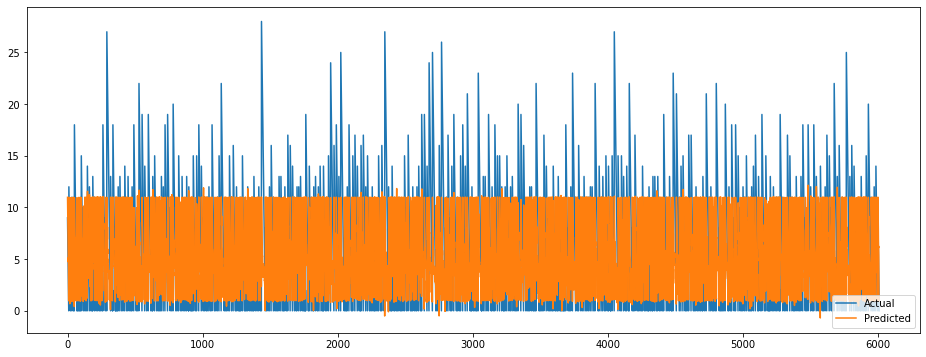

In [31]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_trainY_all)
plt.plot(SVR_trainPredict)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

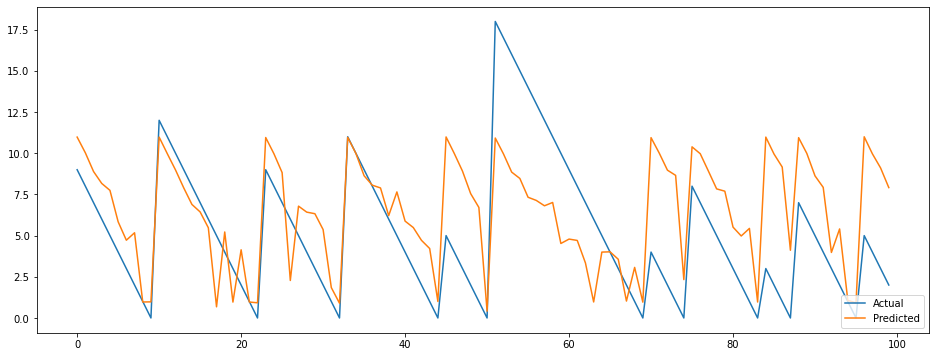

In [32]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_trainY_all[0:100])
plt.plot(SVR_trainPredict[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

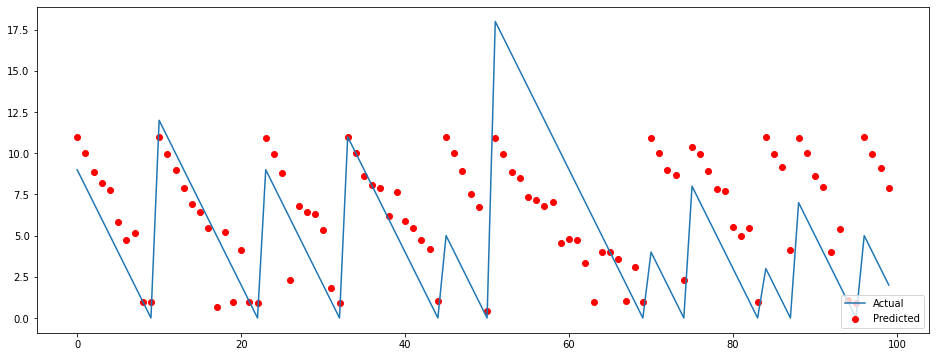

In [33]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_trainY_all[0:100])
plt.scatter(SVR_trainTime_all[0:100], SVR_trainPredict[0:100], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

In [31]:
#evaluate performance of validation set 
SVR_valPredict = SVRmodel.predict(SVR_valX_arr)
SVR_valRMSE = math.sqrt(mean_squared_error(SVR_valY_arr, SVR_valPredict))
SVR_valR2Score = r2_score(SVR_valY_arr, SVR_valPredict)
SVR_valSscore = findSscore(SVR_valY_arr, SVR_valPredict)
print("RMSE of validation set is %f, R2 score of validation set is %f, S score of validation set is %f" % (SVR_valRMSE, SVR_valR2Score, SVR_valSscore))

RMSE of validation set is 3.116333, R2 score of validation set is 0.467413, S score of validation set is 1223.942189


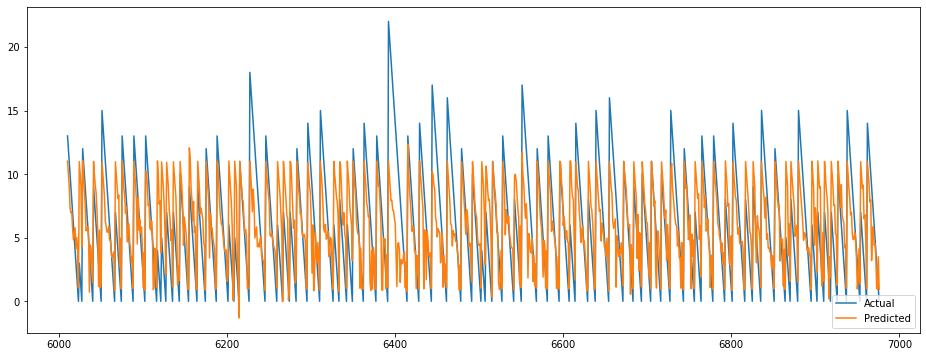

In [32]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_valTime, SVR_valY_arr)
plt.plot(SVR_valTime, SVR_valPredict)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

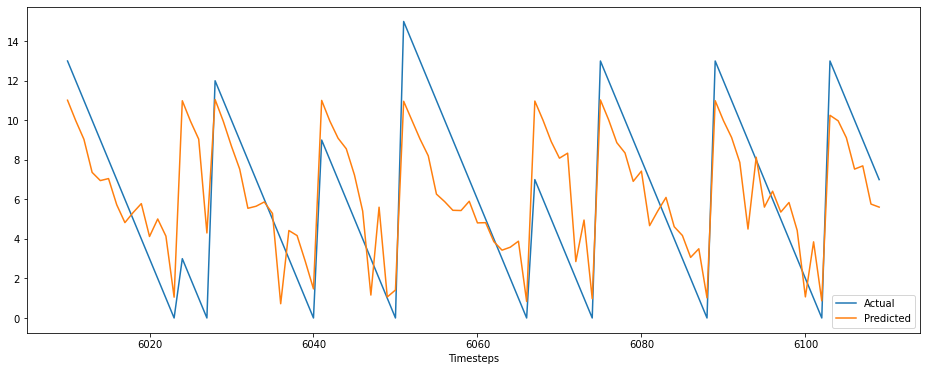

In [33]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_valTime[0:100], SVR_valY_arr[0:100])
plt.plot(SVR_valTime[0:100], SVR_valPredict[0:100])
plt.xlabel('Timesteps')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

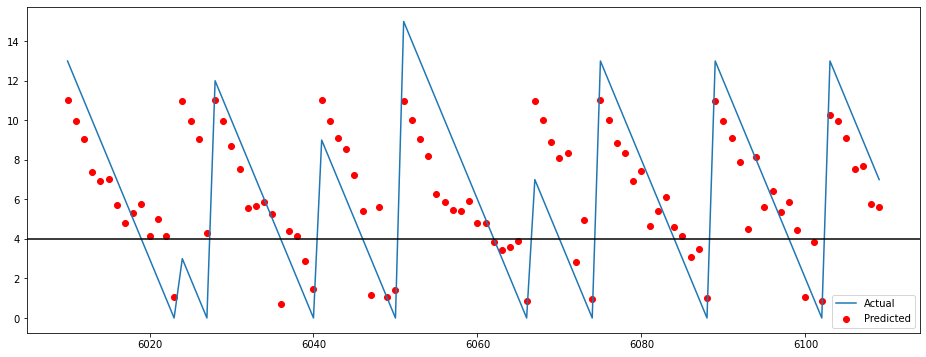

In [37]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_valTime[0:100], SVR_valY_arr[0:100])
plt.scatter(SVR_valTime[0:100], SVR_valPredict[0:100], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.axhline(y=4, color='k', linestyle='-')
plt.show()

In [38]:
#investigate threshold
failureIndexes = []
for order in range(len(SVR_valY_arr)):
    actual = SVR_valY_arr[order]
    if actual < 1:
        failureIndexes.append(order)

In [39]:
indexesOfInterest = []
for i in failureIndexes:
    arr = [i-3, i-2, i-1]
    indexesOfInterest.append(arr)

In [40]:
predictedValuesBeforeFailure = []
predictedValuesBeforeFailureCombine = []
for episode in indexesOfInterest:
    sensorArr = []
    for order in episode:
        predicted = SVR_valPredict[order]
        sensorArr.append(predicted)
        predictedValuesBeforeFailureCombine.append(predicted)
    predictedValuesBeforeFailure.append(sensorArr)

In [41]:
predictedValuesBeforeFailure

[[4.121842000268632, 5.007904850490124, 4.14026402376286],
 [10.98955694717894, 9.953622654994188, 9.046211894749607],
 [4.423749531547972, 4.168238563385811, 2.8636513003871826],
 [1.1593198014352337, 5.603240506677696, 1.0622728862636874],
 [3.430543239040605, 3.579301588174039, 3.8840810217811708],
 [8.337050435198886, 2.8538205262425604, 4.953706276394075],
 [4.172134231993686, 3.0645901772277635, 3.500595588635148],
 [4.42927059736942, 1.0664776994715002, 3.8514678064908985],
 [1.0600709874983143, 4.180296289559982, 3.6768430682946356],
 [9.981583097601245, 7.642566322446221, 7.89922775566152],
 [9.007813218321058, 7.615746902274071, 5.476227653732589],
 [6.425647972169041, 4.790877437410518, 5.64241046975572],
 [5.674277399530015, 1.2900157480292789, 2.7671973586160474],
 [5.39947992315854, 4.444420041729766, 0.9656236169667798],
 [5.41410664351132, 5.877434994390998, 0.9511332771840655],
 [6.45439270069929, 4.5966251559524265, 4.305167531913386],
 [4.558275776805313, 4.138781413

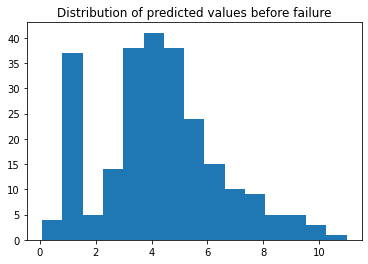

In [42]:
#plot a histogram of values
plt.hist(predictedValuesBeforeFailureCombine, bins='auto')
plt.title('Distribution of predicted values before failure')
plt.show()

In [43]:
def findPercentageFailurePrevented(predictedValueListEpisode, threshold, failureCount):
    avoidedCount = 0
    for episode in predictedValueListEpisode:
        for predicted in episode:
            if predicted < threshold: 
                avoidedCount += 1
                break
    avoidedPercentage = avoidedCount / failureCount
    return avoidedPercentage

In [44]:
failureNum = len(failureIndexes)
failureNum

83

In [45]:
#test threshold = 2
findPercentageFailurePrevented(predictedValuesBeforeFailure, 2, failureNum)

0.4578313253012048

In [46]:
#test threshold = 3
findPercentageFailurePrevented(predictedValuesBeforeFailure, 3, failureNum)

0.5662650602409639

In [47]:
#test threshold = 4
findPercentageFailurePrevented(predictedValuesBeforeFailure, 4, failureNum)

0.7108433734939759

In [48]:
#test threshold = 5
findPercentageFailurePrevented(predictedValuesBeforeFailure, 5, failureNum)

0.891566265060241

In [49]:
#test threshold = 6
findPercentageFailurePrevented(predictedValuesBeforeFailure, 6, failureNum)

0.9518072289156626

Calculate false positive rate